- what are the nearest neighbors of the additional graph structure induced by the adversary?

- Computing something like an "average" subgraph for a class might be difficult because it is unclear how we deal with conflicting directions on edge weights and how we actually average over all the possible subgraphs examples from various classes could elicit
    - But this analysis would be fairly interesting. Should think more about how to do this

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

PERCENTILE = 95

from pt_activation.models.ccff_sigmoid import CCFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/fashion/projected_gradient_descent/ccff_sigmoid.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def get_adv_dists(adversaries, up_to):
    device = torch.device('cpu')
    dists = np.zeros(up_to)
    i = 0
    ims = []
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])), batch_size=1, shuffle=False, **kwargs)
    adv_images = np.array([a['adversary'] for a in adversaries])
    with torch.no_grad():
        for data, target in test_loader:
            d = data.numpy()[0].reshape(28*28)
            ims.append(d)
            dists[i] = np.linalg.norm(d-adv_images[i].reshape(28*28),2)
            i += 1
            if i >= up_to:
                break
            
    return dists, ims, adv_images

def create_sample_graph(f,tnms,wm):

    subgraphs = {}
    m = dion.homology_persistence(f)
    dgm = dion.init_diagrams(m,f)[0]
    for i,c in enumerate(m):
        if len(c) == 2:
            w = f[i].data
            if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
            elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
            if False: #tnms[f[c[0].index][0]] in subgraphs:
                subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(tnms[f[c[0].index][0]]):
                        if tnms[f[c[1].index][0]] in subgraphs:
                            v.add_node(tnms[f[c[1].index][0]])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                        else:
                            v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                    subgraphs[tnms[f[c[0].index][0]]] = g

    return subgraphs, dgm, create_lifetimes(f,subgraphs,dgm,tnms)

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]]
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes



# In[9]:


def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]

    print(adv_images.shape, adv_labels.shape)

    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes

def create_moved_subgraphs(model, ims, labels, devs, batch_size, up_to, times=1):
    device = torch.device("cpu")

    nims = []
    for i in range(len(ims)):
#         print('finding alteration number', i)
        im = ims[i]
        dev = devs[i]
        delim = np.zeros(im.shape, dtype=im.dtype)
        sigma = 0
        while np.linalg.norm(im+delim - im) < dev:
            sigma += 0.00001
            delim = np.random.normal(scale=sigma, size=im.shape)
        nims.append((im+delim).reshape(1,28,28))
    tims = torch.FloatTensor(nims)
    tlabels = torch.tensor(labels)
    print(tims.shape, tlabels.shape, type(tims), type(tlabels))
    dataset = torch.utils.data.TensorDataset(tims, tlabels)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes, nims

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/fashion/ccff_sigmoid.pt'
model = CCFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, sample_graphs, diagrams, lifetimes = create_subgraphs(model, 50, 100)

Filtration: 0
filtration size 63083
Filtration: 1
filtration size 63083
Filtration: 2
filtration size 63083
Filtration: 3
filtration size 63083
Filtration: 4
filtration size 63083
Filtration: 5
filtration size 63083
Filtration: 6
filtration size 63083
Filtration: 7
filtration size 63083
Filtration: 8
filtration size 63083
Filtration: 9
filtration size 63083
Filtration: 10
filtration size 63083
Filtration: 11
filtration size 63083
Filtration: 12
filtration size 63083
Filtration: 13
filtration size 63083
Filtration: 14
filtration size 63083
Filtration: 15
filtration size 63083
Filtration: 16
filtration size 63083
Filtration: 17
filtration size 63083
Filtration: 18
filtration size 63083
Filtration: 19
filtration size 63083
Filtration: 20
filtration size 63083
Filtration: 21
filtration size 63083
Filtration: 22
filtration size 63083
Filtration: 23
filtration size 63083
Filtration: 24
filtration size 63083
Filtration: 25
filtration size 63083
Filtration: 26
filtration size 63083
Filtration:

In [7]:
adv_df, adv_sample_graphs, adv_diagrams, adv_lifetimes = create_adversary_subgraphs(model, 50, 100, adversaries)

torch.Size([1000, 1, 28, 28]) torch.Size([1000])
Filtration: 0
filtration size 63083
Filtration: 1
filtration size 63083
Filtration: 2
filtration size 63083
Filtration: 3
filtration size 63083
Filtration: 4
filtration size 63083
Filtration: 5
filtration size 63083
Filtration: 6
filtration size 63083
Filtration: 7
filtration size 63083
Filtration: 8
filtration size 63083
Filtration: 9
filtration size 63083
Filtration: 10
filtration size 63083
Filtration: 11
filtration size 63083
Filtration: 12
filtration size 63083
Filtration: 13
filtration size 63083
Filtration: 14
filtration size 63083
Filtration: 15
filtration size 63083
Filtration: 16
filtration size 63083
Filtration: 17
filtration size 63083
Filtration: 18
filtration size 63083
Filtration: 19
filtration size 63083
Filtration: 20
filtration size 63083
Filtration: 21
filtration size 63083
Filtration: 22
filtration size 63083
Filtration: 23
filtration size 63083
Filtration: 24
filtration size 63083
Filtration: 25
filtration size 63083

In [8]:
dists, ims, adv_ims = get_adv_dists(adversaries, 100)

In [9]:
moved_df, moved_sample_graphs, moved_diagrams, moved_lifetimes, moved_ims = create_moved_subgraphs(model, ims, res_df['class'], dists, 100, 100, times=1)

torch.Size([100, 1, 28, 28]) torch.Size([100]) <class 'torch.Tensor'> <class 'torch.Tensor'>
Filtration: 0
filtration size 63083
Filtration: 1
filtration size 63083
Filtration: 2
filtration size 63083
Filtration: 3
filtration size 63083
Filtration: 4
filtration size 63083
Filtration: 5
filtration size 63083
Filtration: 6
filtration size 63083
Filtration: 7
filtration size 63083
Filtration: 8
filtration size 63083
Filtration: 9
filtration size 63083
Filtration: 10
filtration size 63083
Filtration: 11
filtration size 63083
Filtration: 12
filtration size 63083
Filtration: 13
filtration size 63083
Filtration: 14
filtration size 63083
Filtration: 15
filtration size 63083
Filtration: 16
filtration size 63083
Filtration: 17
filtration size 63083
Filtration: 18
filtration size 63083
Filtration: 19
filtration size 63083
Filtration: 20
filtration size 63083
Filtration: 21
filtration size 63083
Filtration: 22
filtration size 63083
Filtration: 23
filtration size 63083
Filtration: 24
filtration siz

In [10]:
print('Moved Accuracy:', moved_df[moved_df['prediction'] == moved_df['class']].shape[0]/moved_df.shape[0])
print('Actual Accuracy:', res_df[res_df['prediction'] == res_df['class']].shape[0]/res_df.shape[0])
print('Adversary Accuracy:', adv_df[adv_df['prediction'] == adv_df['class']].shape[0]/adv_df.shape[0])

Moved Accuracy: 0.74
Actual Accuracy: 0.74
Adversary Accuracy: 0.02


In [11]:
res_df.head()

,class,loss,prediction
0,9,0.615138,9
1,2,0.615138,2
2,1,0.615138,1
3,1,0.615138,1
4,6,0.615138,6


In [12]:
goi = 1

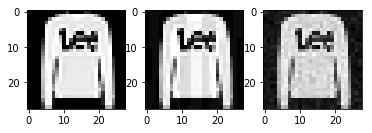

In [13]:
plt.subplot(131).imshow(ims[goi].reshape(28,28), cmap='gray')
plt.subplot(132).imshow(adv_ims[goi].reshape(28,28), cmap='gray')
plt.subplot(133).imshow(moved_ims[goi].reshape(28,28), cmap='gray')

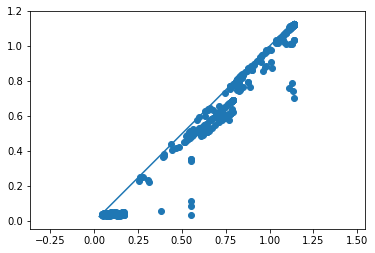

In [14]:
dion.plot.plot_diagram(diagrams[goi])

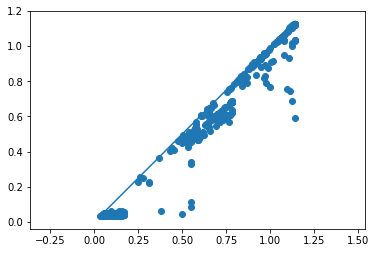

In [15]:
dion.plot.plot_diagram(adv_diagrams[goi])

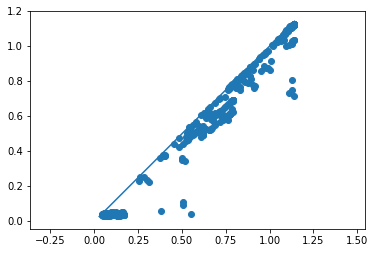

In [16]:
dion.plot.plot_diagram(moved_diagrams[goi])

In [17]:
lifetimes[goi]

{(1, 1, 261): 1.1422008275985718,
 (1, 1, 237): 0.016346216201782227,
 (1, 1, 213): 0.016345620155334473,
 (1, 1, 285): 0.01629924774169922,
 (1, 1, 309): 0.01625800132751465,
 (1, 1, 189): 0.01634371280670166,
 (1, 1, 333): 0.01622450351715088,
 (1, 1, 357): 0.016273856163024902,
 (1, 1, 381): 0.016279220581054688,
 (1, 1, 92): 0.10777914524078369,
 (1, 1, 429): 0.01634073257446289,
 (1, 1, 405): 0.016327857971191406,
 (1, 1, 453): 0.01631033420562744,
 (1, 1, 477): 0.016330718994140625,
 (1, 1, 165): 0.016338706016540527,
 (1, 1, 116): 0.016178131103515625,
 (1, 1, 549): 0.016427040100097656,
 (1, 1, 525): 0.016337871551513672,
 (1, 1, 501): 0.01611471176147461,
 (1, 1, 150): 0.43951547145843506,
 (1, 1, 140): 0.016083836555480957,
 (1, 1, 126): 0.016333818435668945,
 (1, 1, 164): 0.01585555076599121,
 (1, 1, 141): 0.01632702350616455,
 (1, 1, 68): 0.01632368564605713,
 (1, 1, 502): 0.1080176830291748,
 (1, 1, 526): 0.016296982765197754,
 (1, 1, 188): 0.015869736671447754,
 (1, 1, 55

In [18]:
adv_lifetimes[goi]

{(1, 1, 92): 1.1418746709823608,
 (1, 1, 150): 0.552369236946106,
 (1, 1, 116): 0.016193509101867676,
 (1, 1, 126): 0.016338229179382324,
 (1, 1, 213): 0.10811316967010498,
 (1, 1, 237): 0.016292929649353027,
 (1, 1, 261): 0.01625657081604004,
 (1, 1, 189): 0.016334891319274902,
 (1, 1, 285): 0.016231536865234375,
 (1, 1, 140): 0.01591336727142334,
 (1, 1, 309): 0.016139626502990723,
 (1, 1, 333): 0.01606452465057373,
 (1, 1, 165): 0.016326904296875,
 (1, 1, 357): 0.016174793243408203,
 (1, 1, 68): 0.01632559299468994,
 (1, 1, 477): 0.0164334774017334,
 (1, 1, 405): 0.016344785690307617,
 (1, 1, 525): 0.016562342643737793,
 (1, 1, 549): 0.016321778297424316,
 (1, 1, 381): 0.016167759895324707,
 (1, 1, 453): 0.016323566436767578,
 (1, 1, 429): 0.016288399696350098,
 (1, 1, 164): 0.015541911125183105,
 (1, 1, 174): 0.014968037605285645,
 (1, 1, 67): 0.10673356056213379,
 (1, 1, 501): 0.016007661819458008,
 (1, 1, 141): 0.016307353973388672,
 (1, 1, 502): 0.10788452625274658,
 (1, 1, 188)

In [19]:
moved_lifetimes[goi]

{(1, 1, 213): 1.142242670059204,
 (1, 1, 285): 0.01637411117553711,
 (1, 1, 261): 0.016346096992492676,
 (1, 1, 237): 0.01628899574279785,
 (1, 1, 309): 0.016306281089782715,
 (1, 1, 357): 0.016454577445983887,
 (1, 1, 189): 0.016344547271728516,
 (1, 1, 381): 0.01629197597503662,
 (1, 1, 405): 0.016341686248779297,
 (1, 1, 429): 0.01633167266845703,
 (1, 1, 92): 0.1079561710357666,
 (1, 1, 333): 0.016178488731384277,
 (1, 1, 453): 0.01627671718597412,
 (1, 1, 116): 0.01618945598602295,
 (1, 1, 165): 0.016341090202331543,
 (1, 1, 477): 0.01610851287841797,
 (1, 1, 525): 0.01643502712249756,
 (1, 1, 140): 0.01601850986480713,
 (1, 1, 501): 0.016048550605773926,
 (1, 1, 150): 0.42792248725891113,
 (1, 1, 549): 0.016125202178955078,
 (1, 1, 141): 0.016333580017089844,
 (1, 1, 126): 0.01633310317993164,
 (1, 1, 68): 0.01633286476135254,
 (1, 1, 164): 0.015560507774353027,
 (1, 1, 430): 0.10800909996032715,
 (1, 1, 454): 0.01630699634552002,
 (1, 1, 502): 0.01708662509918213,
 (1, 1, 188): 

In [20]:
# sgk = (1,0,544)
# agk = (1,0,544)
# mgk = sgk

In [21]:
# options = {
#     'node_color': 'red',
#     'node_size': 2,
#     'width': 2,
#     'with_labels':True}
# nx.draw_spring(sample_graphs[goi][sgk], **options)

In [22]:
# options = {
#     'node_color': 'red',
#     'node_size': 2,
#     'width': 2,
#     'with_labels':True}
# nx.draw_spring(adv_sample_graphs[goi][agk], **options)

In [23]:
# options = {
#     'node_color': 'red',
#     'node_size': 2,
#     'width': 2,
#     'with_labels':True}
# nx.draw_spring(moved_sample_graphs[goi][mgk], **options)

In [24]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def full_weighted_edge_distance(subgraphs1, subgraphs2):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = np.ones(len(subgraphs1))
    lifetimes2 = np.ones(len(subgraphs2))
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]

    
    return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [25]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

,class,loss,prediction
35,0,0.615138,0
59,0,0.552594,0
19,0,0.615138,0
96,0,0.552594,0
71,0,0.552594,0


In [26]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

adv_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(adv_sample_graphs)):
#         adv_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])
        adv_sim_mat[i,j] = 1 - full_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j])
        

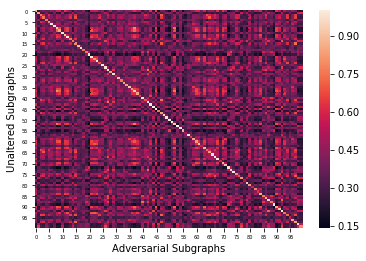

In [27]:
ax = sns.heatmap(adv_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_fashion/adv_comb_heatmap_sigmoid.png', format='png', dpi=500)

In [28]:
moved_sim_mat = np.zeros((len(sample_graphs), len(moved_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(moved_sample_graphs)):
#         moved_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],moved_sample_graphs[j],lifetimes[i],moved_lifetimes[j])
        moved_sim_mat[i,j] = 1 - full_weighted_edge_distance(sample_graphs[i],moved_sample_graphs[j])
        

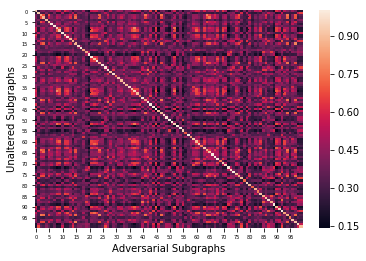

In [29]:
ax = sns.heatmap(moved_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_fashion/moved_comb_heatmap_sigmoid.png', format='png', dpi=500)

In [30]:
# moved_dists = np.array([get_adv_dist(ims[i], moved_ims[i]) for i in range(res_df.shape[0])])

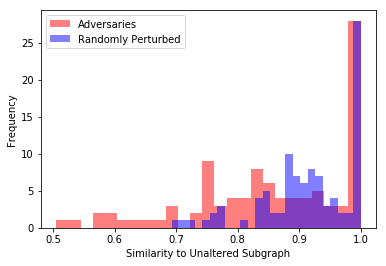

In [31]:
bins = 25
plt.hist(np.diagonal(adv_sim_mat), bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(np.diagonal(moved_sim_mat), bins, alpha=0.5, label='Randomly Perturbed', color='b')
plt.xlabel('Similarity to Unaltered Subgraph')
plt.ylabel('Frequency')
plt.legend()

Text(0.5, 0, 'Random Perturbation Similarity')

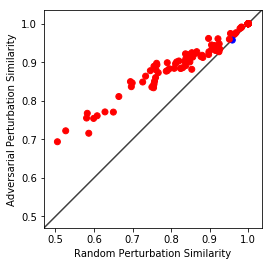

In [59]:
fig, ax = plt.subplots()
differs = np.diagonal(adv_sim_mat) - np.diagonal(moved_sim_mat)
colors = ['b' if differs[i] > 0 else 'r' for i in range(len(moved_num_generators))]
ax.scatter(np.diagonal(adv_sim_mat), np.diagonal(moved_sim_mat), c=colors)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.ylabel('Adversarial Perturbation Similarity')
plt.xlabel('Random Perturbation Similarity')

In [51]:
differs[differs <= 0].shape[0]/len(moved_num_generators)

0.99

In [32]:
# bins = 25
# plt.hist(dists, bins, alpha=0.5, label='Adversaries', color='r')
# plt.hist(moved_dists, bins, alpha=0.5, label='Random Pertubation', color='b')
# plt.xlabel('Distance to Unaltered Image')
# plt.ylabel('Frequency')
# plt.legend()

In [33]:
def compute_num_generators(g):
    return len(g)
def compute_num_edges(g):
    num_edges = 0
    for sgk in g:
        num_edges += len(g[sgk].edges())
    return num_edges

In [34]:
num_generators = [compute_num_generators(g) for g in sample_graphs]
adv_num_generators = [compute_num_generators(g) for g in adv_sample_graphs]
moved_num_generators = [compute_num_generators(g) for g in moved_sample_graphs]

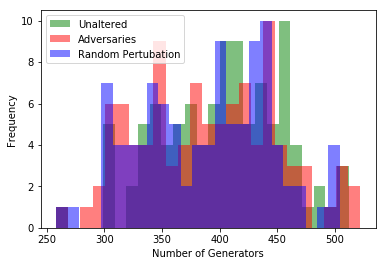

In [35]:
bins = 25
plt.hist(num_generators, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_generators, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_generators, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Generators')
plt.ylabel('Frequency')
plt.legend()

(244.7901433691756, 535.2098566308243)

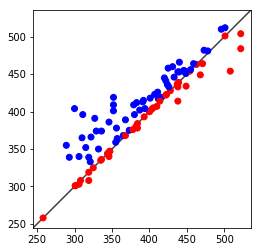

In [52]:
fig, ax = plt.subplots()
differs = np.array(num_generators) - np.array(adv_num_generators)
colors = ['b' if differs[i] > 0 else 'r' for i in range(len(moved_num_generators))]
ax.scatter(np.array(adv_num_generators), np.array(num_generators), c=colors)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [54]:
differs[differs >= 0].shape[0]/len(moved_num_generators)

0.83

(244.78482339955843, 535.2151766004415)

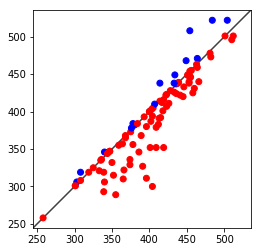

In [36]:
fig, ax = plt.subplots()
differs = np.array(adv_num_generators) - np.array(num_generators)
colors = ['b' if differs[i] > 0 else 'r' for i in range(len(moved_num_generators))]
ax.scatter(num_generators, adv_num_generators, c=colors)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

0.99

In [37]:
num_edges = [compute_num_edges(g) for g in sample_graphs]
adv_num_edges = [compute_num_edges(g) for g in adv_sample_graphs]
moved_num_edges = [compute_num_edges(g) for g in moved_sample_graphs]

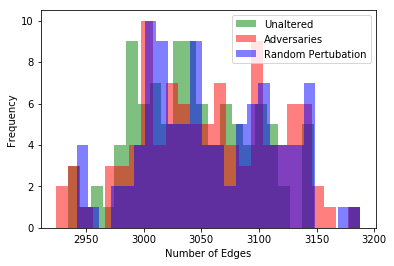

In [38]:
bins = 25
plt.hist(num_edges, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_edges, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_edges, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Edges')
plt.ylabel('Frequency')
plt.legend()

(2910.7848233995583, 3201.2151766004413)

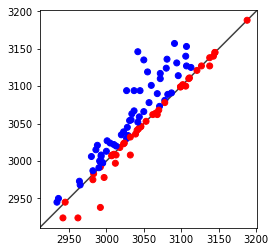

In [39]:
fig, ax = plt.subplots()
differs = np.array(adv_num_edges) - np.array(num_edges)
colors = ['b' if differs[i] > 0 else 'r' for i in range(len(moved_num_edges))]
ax.scatter(num_edges, adv_num_edges, c=colors)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [40]:
differs[differs >= 0].shape[0]/len(num_edges)

0.83

- Compute the set differences for each adversary and compare these set differences to each of the unaltered images like we did for the adv_sim_mat above. 
- Sort this similarity matrix by the _predicted_ class of the adversary. We would expect to see some sort of relationship emerge if these subgraphs were targeting class-specific information within the persistent subgraphs
- Compute these differences based on the composed graphs like in `lifetime_weighted_edge_distance()`

In [41]:
def set_difference(subgraphs1, subgraphs2):
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    remove_edges = []
    edges2 = []
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        remove_edges += list(g.edges)
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        edges2 += list(g.edges)
    keep_edges = set(edges2).difference(set(remove_edges))
    ret_graph = nx.compose_all([subgraphs2[k] for k in sg2keys])
    rge = list(ret_graph.edges())
    ret_graph.remove_edges_from(e for e in rge if e not in keep_edges)
    return ret_graph

In [42]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_adv_df = adv_df.sort_values(by=['prediction'])

In [43]:
sorted_adv_df.head(40)

,class,loss,prediction
80,1,1.075316,0
86,3,1.075316,0
64,1,1.075316,0
5,1,1.058432,0
91,3,1.075316,0
75,3,1.075316,0
2,1,1.058432,0
40,6,1.058432,0
13,3,1.058432,1
79,4,1.075316,2


In [44]:
adv_differences = [set_difference(sample_graphs[i], adv_sample_graphs[i]) for i in range(len(sample_graphs))]

combs = []
for i in range(len(sample_graphs)):
    combs.append(nx.compose_all([sample_graphs[i][k] for k in sample_graphs[i]]))

In [45]:
diff_sim_mat = np.zeros((len(combs),len(adv_differences)))
for i in range(len(combs)):
    g = combs[i]
    for j in range(len(adv_differences)):
        ag = adv_differences[j]
        diff_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

/home/tgebhart/.local/lib/python3.6/site-packages/scipy/spatial/distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [46]:
sorted_diff_sim_mat = np.empty(diff_sim_mat.shape)
sidxs = list(sorted_adv_df.index)
# aidxs = list(sorted_adv_df.index)
aidxs = sidxs
for i in range(len(sidxs)):
    for j in range(len(aidxs)):
        sorted_diff_sim_mat[i,j] = diff_sim_mat[sidxs[i],aidxs[j]]
        
sdsmdf = pd.DataFrame(sorted_diff_sim_mat, columns=sorted_adv_df['prediction'], index=sorted_res_df['prediction'])

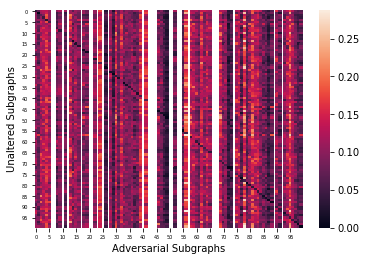

In [47]:
ax = sns.heatmap(diff_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/ccff_fashion/adv_diff_heatmap_sigmoid.png', format='png', dpi=500)